In [2]:
from openfisca_uk.api import *
from analysis import lvt_reforms, lvt_names, IMPUTED_LAND_VALUE

In [79]:
results[1:6]

,Unnamed: 0,Poverty,Deep poverty,Adult poverty,Child poverty,Senior poverty,Inequality,Winner share,Loser share,UBI
1,1% LVT,-0.159280,-0.167793,-0.145447,-0.310894,0.013874,-0.027914,0.684959,0.311216,841.900024
2,2% LVT,-0.269324,-0.102471,-0.235037,-0.538904,0.017118,-0.046930,0.685339,0.311235,1683.790039
3,3% LVT,-0.335110,-0.003451,-0.293263,-0.674494,0.028416,-0.059230,0.685590,0.311235,2525.689941
4,4% LVT,-0.343282,0.216101,-0.297109,-0.755403,0.108430,-0.065021,0.685715,0.311235,3367.590088
5,5% LVT,-0.310980,0.585954,-0.270071,-0.788525,0.240307,-0.064953,0.685757,0.311235,4209.490234


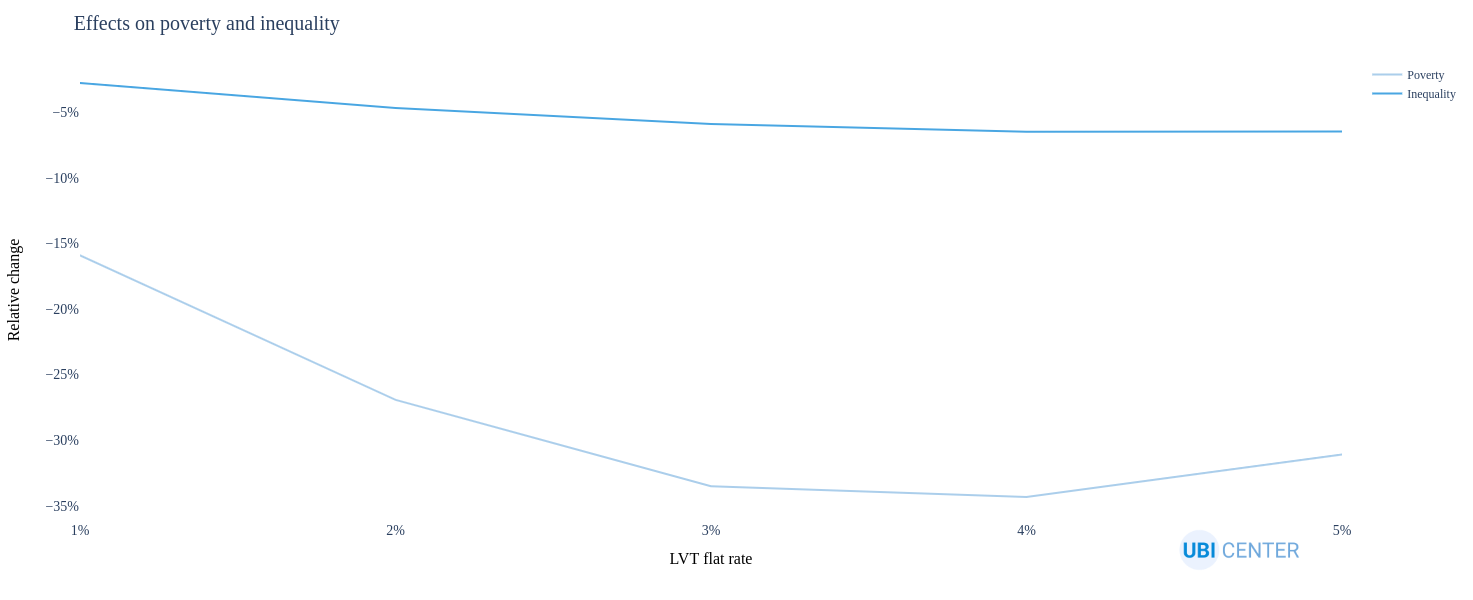

In [81]:
import pandas as pd
import plotly.express as px
from ubicenter import format_fig
from ubicenter.plotly import DARK_BLUE, LIGHT_BLUE, BLUE_COLOR_SEQUENCE

results = pd.read_csv("results.csv")

format_fig(px.line(results[1:6], x=[0.01, 0.02, 0.03, 0.04, 0.05], y=["Poverty", "Inequality"], color_discrete_sequence=BLUE_COLOR_SEQUENCE).update_layout(xaxis_title="LVT flat rate", xaxis_tickformat="%", xaxis_tickvals=(0.01, 0.02, 0.03, 0.04, 0.05), title="Effects on poverty and inequality", yaxis_title="Relative change", yaxis_tickformat="%", legend_title=""))

In [89]:
baseline = Microsimulation()

outcomes = {
    "Lose more than 5%": [],
    "Lose less than 5%": [],
    "Gain less than 5%": [],
    "Gain more than 5%": []
}
for reform in lvt_reforms:
    reformed = Microsimulation(reform)
    reformed.simulation.set_input("land_value", 2021, IMPUTED_LAND_VALUE)
    equiv_income = baseline.calc("equiv_household_net_income", map_to="person")
    income = baseline.calc("household_net_income", map_to="person")
    change = reformed.calc("household_net_income", map_to="person") - income
    rel_change = change / income
    outcomes["Lose more than 5%"] += [(rel_change < -0.05).mean()]
    outcomes["Lose less than 5%"] += [((rel_change >= -0.05) & (rel_change < 0)).mean()]
    outcomes["Gain less than 5%"] += [((rel_change >= 0) & (rel_change < 0.05)).mean()]
    outcomes["Gain more than 5%"] += [(rel_change > 0.05).mean()]

outcome_df = pd.DataFrame(outcomes)

In [90]:
outcome_df.index = lvt_names

In [99]:
outcome_df.columns = outcome_df.columns[::-1]

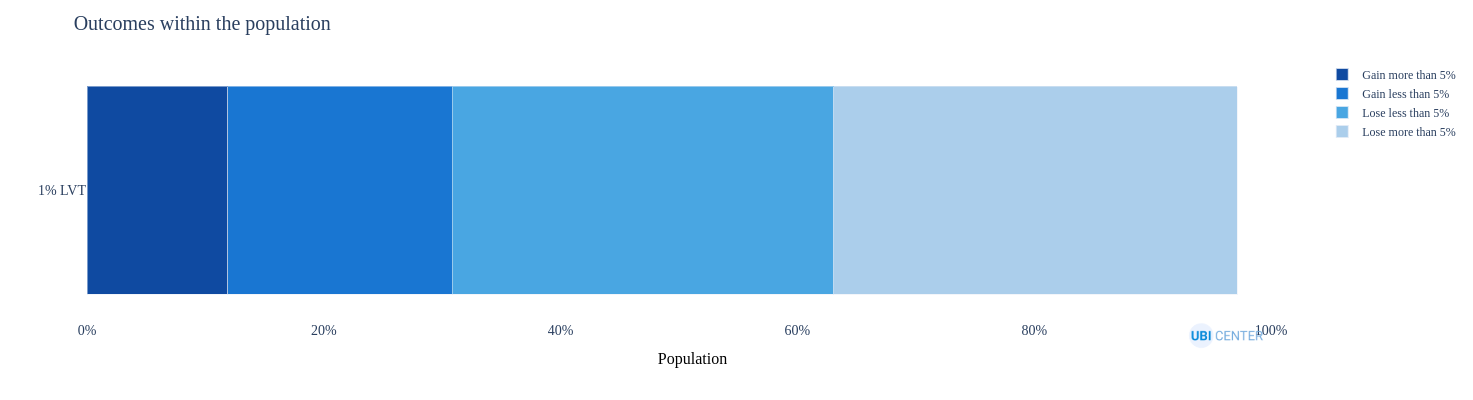

In [113]:
format_fig(px.bar(outcome_df[1:2][::-1], barmode="stack", orientation="h", color_discrete_sequence=BLUE_COLOR_SEQUENCE[::-1]).update_layout(xaxis_title="Population", xaxis_tickformat="%", yaxis_title="", legend_title="", title="Outcomes within the population"), show=False).update_layout(width=800, height=400)

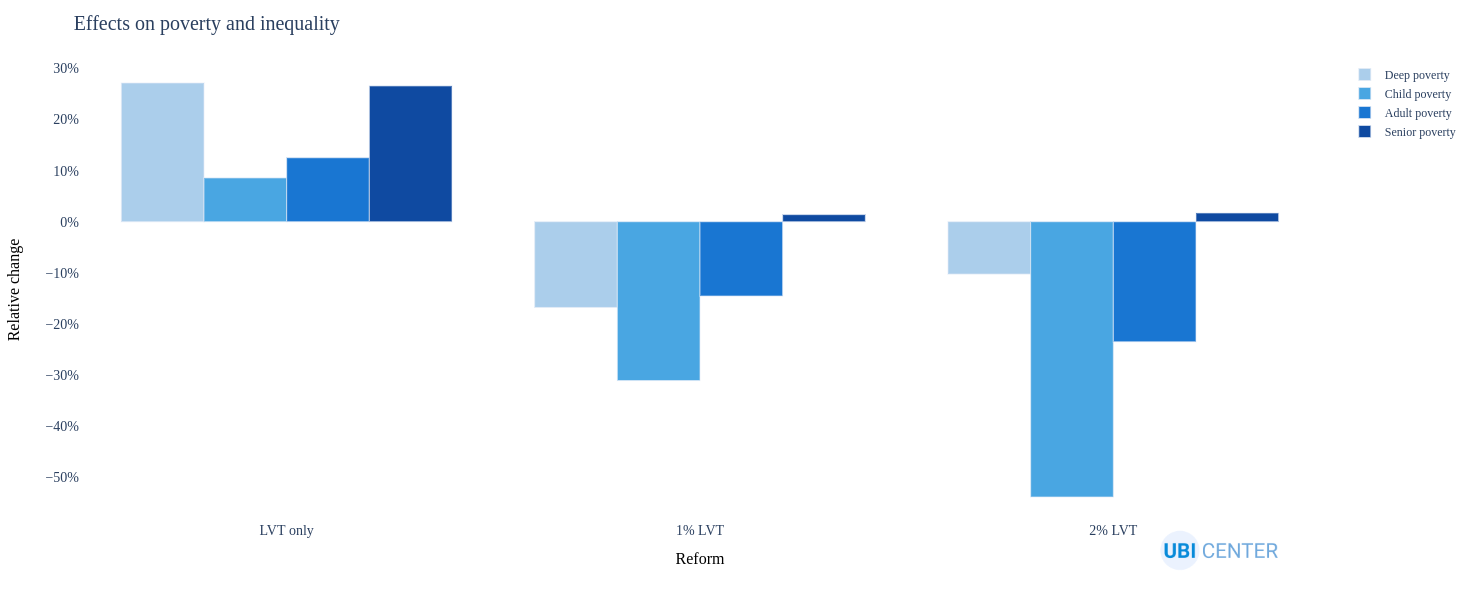

In [61]:
import pandas as pd
import plotly.express as px
from ubicenter import format_fig
from ubicenter.plotly import BLUE_COLOR_SEQUENCE

results = pd.read_csv("results.csv")
results["Reform"] = lvt_names

format_fig(px.bar(results[:3], x="Reform", y=["Deep poverty", "Child poverty", "Adult poverty", "Senior poverty"], barmode="group", color_discrete_sequence=BLUE_COLOR_SEQUENCE).update_layout(title="Effects on poverty and inequality", yaxis_title="Relative change", yaxis_tickformat="%", legend_title=""))

In [36]:
def get_decile_chart(reform, baseline=None, name="", **kwargs):
    baseline = baseline or Microsimulation()
    reformed = Microsimulation(reform)
    reformed.simulation.set_input("land_value", 2021, IMPUTED_LAND_VALUE)
    equiv_income = baseline.calc("equiv_household_net_income", map_to="person")
    income = baseline.calc("household_net_income", map_to="person")
    change = reformed.calc("household_net_income", map_to="person") - income

    decile_changes = change.groupby(equiv_income.decile_rank()).sum() / income.groupby(equiv_income.decile_rank()).sum()
    
    return pd.DataFrame({
        "Decile": decile_changes.index,
        "Change": decile_changes.values,
        "Reform": name
    })

    return format_fig(px.bar(decile_changes).update_layout(title="Changes to net income", yaxis_tickformat="%", xaxis_title="Income decile", yaxis_title="Change to net income", showlegend=False))

baseline = Microsimulation()
decile_df = pd.concat([get_decile_chart(reform, baseline=baseline, name=name) for reform, name in zip(lvt_reforms, lvt_names)])

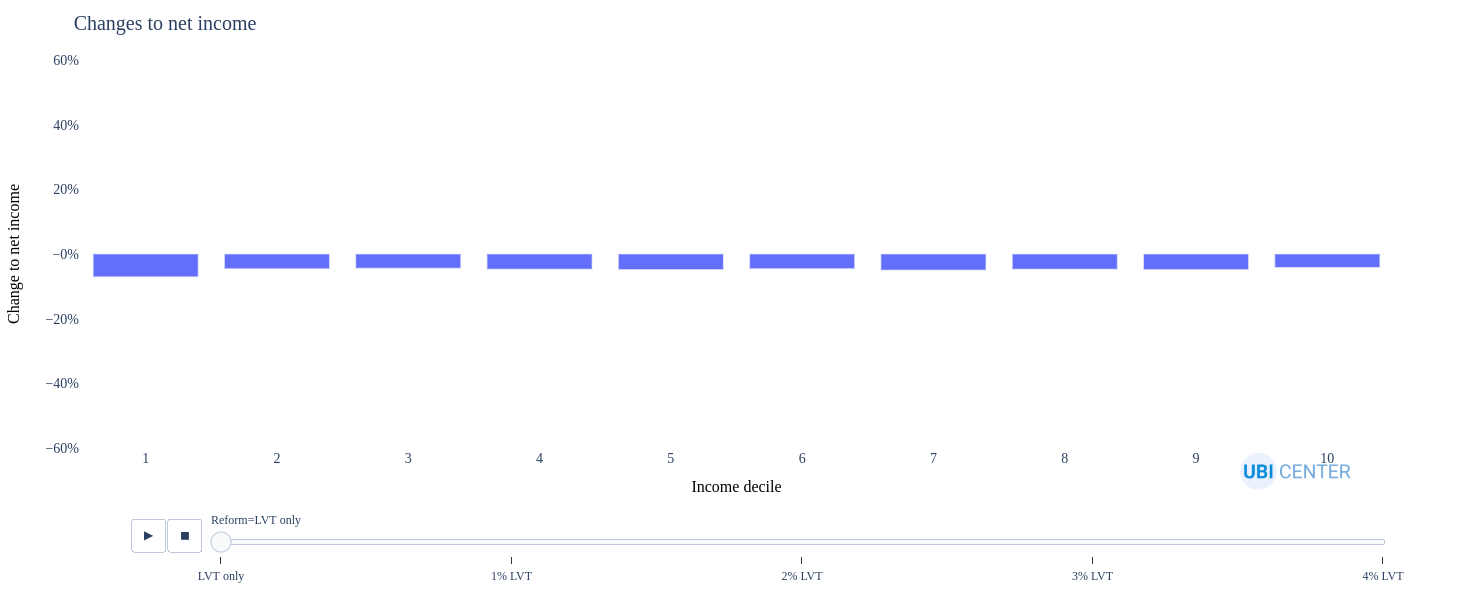

In [46]:
format_fig(px.bar(decile_df, animation_frame="Reform", x="Decile", y="Change").update_layout(xaxis_tickvals=list(range(1, 11)), yaxis_range=(-0.6, 0.6), title="Changes to net income", yaxis_tickformat="%", xaxis_title="Income decile", yaxis_title="Change to net income", showlegend=False))